In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from qutip import Qobj, sesolve
import os

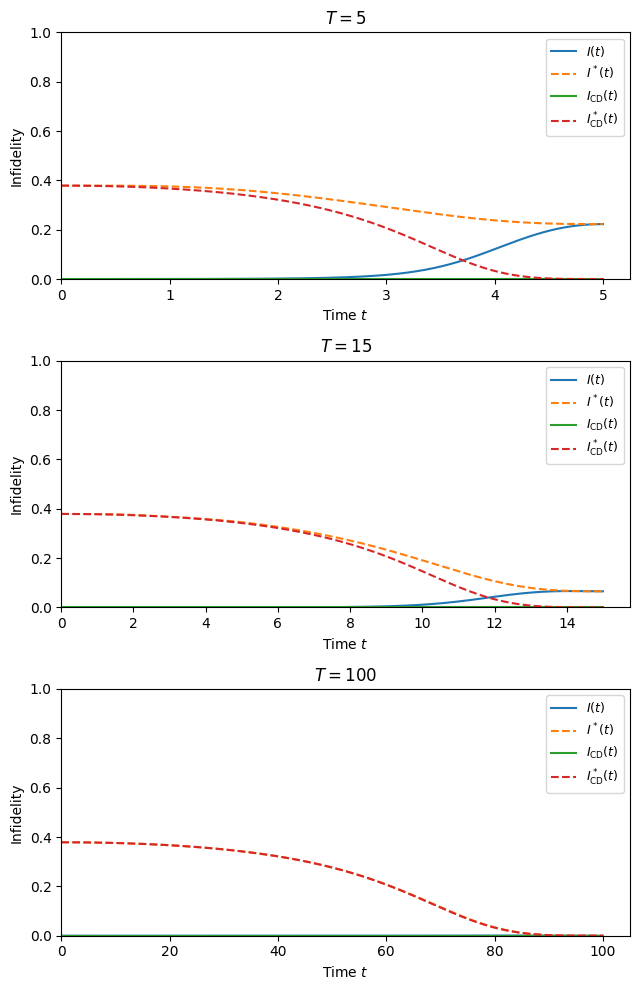

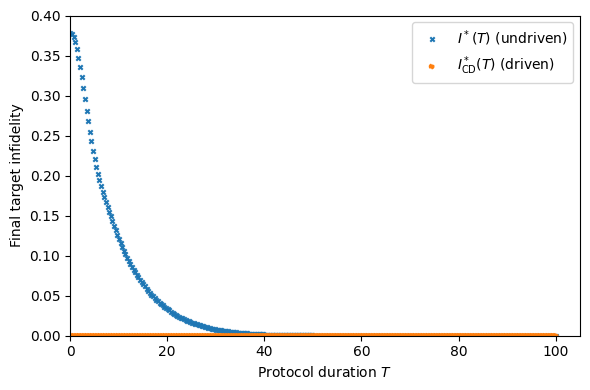

In [ ]:
#####################
# Define Variables and Relevant Functions
#####################

J = 1 # satisfies initial condition h(0)/J = 1
T_vals = np.linspace(0.05, 100, 300)
T_plot = [5, 15, 100]
# T_vals = [0.05, 1, 5, 10, 11, 20, 100]
N_t_plot = 400
N_t_scan = 80
I_star_final, I_star_final_driven = np.zeros(len(T_vals)), np.zeros(len(T_vals))

def control(t, T):
    """Transverse field h(t) = cos^2(pi * t/(2 * T))"""
    return np.cos((np.pi * t) / (2 * T))**2

def control_deriv(t, T):
    """h_dot (t) = -pi/(2T) * sin(pi * t/T)
        This is used to build the counterdiabatically driven Hamiltonian H_{CD}"""
    return (-np.pi / (2 * T)) * np.sin((np.pi * t) / T)

def hamiltonian(t, T, J):
    """4x4 Hamiltonian matrix in the basis [uu, dd, ud, du]
        We are taking hbar = 1 for simplicity"""
    h = control(t, T)
    a, b, c = J/4, -J/4, h/2
    return np.array([
        [a, 0, c, c],
        [0, a, c, c],
        [c, c, b, 0],
        [c, c, 0, b]
    ], dtype=complex)

def K_matrix():
    """4x4 matrix corresponding to just the (S^x_1 + S^x_2) piece of the original Hamiltonian H(t),
        i.e. without the h(t) factor in.
        This is used to build the counterdiabatically driven Hamiltonian H_{CD}.
        Remember we are taking hbar=1"""
    a = 1/2
    return np.array([
        [0, 0, a, a],
        [0, 0, a, a],
        [a, a, 0, 0],
        [a, a, 0, 0]
    ], dtype=complex)
K = K_matrix()

def hamiltonian_cd(t, T, J):
    """Build the counterdiabatically driven Hamiltonian H_cd from the original undriven Hamiltonian,
            in the [uu, dd, ud, du] basis.
        The Berry formula for the gauge potential piece is defined in terms of the instantaneous eigenbasis,
            so we need to transform between this and the [uu, dd, ud, du] basis."""
    
    # Diagonalise original Hamiltonian
    H_t = hamiltonian(t, T, J)
    values, vectors = np.linalg.eigh(H_t)   # values sorted ascending

    # Now build the new gauge potential piece
    U_dag = vectors.conj().T
    transformed_K = U_dag @ K @ vectors

    denom = values[None, :] - values[:, None]   # Matrix of energy differences: (m,n) -> E_n - E_m, shape (4, 4)
    nondegen_mask = np.abs(denom) > 1e-12
    offdiag_mask = (~np.eye(len(values), dtype=bool)) & nondegen_mask # mask out diagonal to avoid dividing by 0
    A_h = np.zeros_like(transformed_K, dtype=complex)
    A_h[offdiag_mask] = 1j * transformed_K[offdiag_mask] / denom[offdiag_mask] # Fill in off-diagonal entries only, leave diagonal zero (gauge choice)

    A_h_comp_basis = vectors @ A_h @ U_dag
    H_cd = H_t + control_deriv(t, T) * A_h_comp_basis

    return H_cd

def schrodinger_rhs(t, y, J, T):
    """This function computes the right hand side of the Schroedinger equation when written as d(psi)/dt = -i/hbar * H @ psi.
            This will be useful later when solving the Schroedinger equation to time-evolve states using the solve_ivp method.
            Note that this function is set up for the original undriven Hamiltonian.
            Again let's take hbar = 1 for simplicity"""
    H = hamiltonian(t, T, J)
    # rhs = np.matmul(H, y)
    # return -1j * rhs
    return -1j * (H @ y)

def schrodinger_rhs_cd(t, y, J, T):
    """This function computes the right hand side of the Schroedinger equation when written as d(psi)/dt = -i/hbar * H @ psi.
            This will be useful later when solving the Schroedinger equation to time-evolve states using the solve_ivp method.
            Note that this function is set up for the hamiltonian_cd.
            Again let's take hbar = 1 for simplicity"""
    H = hamiltonian_cd(t, T, J)
    return -1j * (H @ y)

def qt_hamiltonian(t, args):
    """Define the Hamiltonian using the qutip library.
        This will be useful to solve the Schroedinger equation later (using QuTip instead of solve_ivp)"""
    J = args['J']
    T = args['T']
    H_np = hamiltonian(t, T, J)
    return Qobj(H_np)

def qt_hamiltonian_cd(t, args):
    """Define the driven Hamiltonian using the qutip library.
        This will be useful to solve the Schroedinger equation later (using QuTip instead of solve_ivp)"""
    J = args['J']
    T = args['T']
    H_np = hamiltonian_cd(t, T, J)
    return Qobj(H_np)

#####################
# Pipeline to Find Infidelities
#####################

# for k, T in enumerate(T_vals):
def compute_infidelities_both(T, N_t):
    t_vals = np.linspace(0, T, N_t)

    # region
    #####################
    # Diagonalise Original Hamiltonian
    #####################

    # storage: eigenvalues [N_t, 4], eigenvectors [N_t, 4, 4]
    e_vals = np.zeros((N_t, 4), dtype=float)
    e_vecs = np.zeros((N_t, 4, 4), dtype=complex)

    for i, t in enumerate(t_vals):
        H_t = hamiltonian(t, T, J)
        values, vectors = np.linalg.eigh(H_t)   # values sorted ascending
        e_vals[i, :] = values
        e_vecs[i, :, :] = vectors             # columns are eigenvectors

    # Store the instantaneous ground states of the original Hamiltonian
    ground_energies = e_vals[:, 0]        # shape (N_t,)
    ground_states  = e_vecs[:, :, 0]      # shape (N_t, 4)

    psi_init = ground_states[0]
    psi_star = np.array([0, 0, 1/np.sqrt(2), 1/np.sqrt(2)], dtype=complex)
    # endregion

    #region
    #####################
    # Solve Time-Dependent Schroedinger Eqn (for both hamiltonians)
    #####################

    # ---- Now using QuTip instead ----
    psi0 = Qobj(psi_init)  # initial condition as Qobj ket
    args = {'J': J, 'T': T}

    sol = sesolve(qt_hamiltonian, psi0, t_vals, e_ops=[], args=args)
    psi_t_original_list = sol.states                     # list of length N_t
    psi_t_original = np.vstack([psi.full().ravel() for psi in psi_t_original_list])  # (N_t, 4)

    sol_cd = sesolve(qt_hamiltonian_cd, psi0, t_vals, e_ops=[], args=args)
    psi_t_driven_list = sol_cd.states
    psi_t_driven = np.vstack([psi.full().ravel() for psi in psi_t_driven_list])
    # endregion

    #region
    #####################
    # Calculate Infidelities
    #####################

    I  = np.zeros(N_t)
    I_star = np.zeros(N_t) # original infidelities
    I_driven  = np.zeros(N_t)
    I_star_driven = np.zeros(N_t) # driven infidelities

    for i in range(N_t):
        I[i]      = 1 - np.abs(np.vdot(ground_states[i], psi_t_original[i]))**2
        I_star[i] = 1 - np.abs(np.vdot(psi_star, psi_t_original[i]))**2
        I_driven[i]      = 1 - np.abs(np.vdot(ground_states[i], psi_t_driven[i]))**2
        I_star_driven[i] = 1 - np.abs(np.vdot(psi_star, psi_t_driven[i]))**2
    
    I[-1] = 1 - np.abs(np.vdot(psi_star, psi_t_original[i]))**2
    I_driven[-1] = 1 - np.abs(np.vdot(psi_star, psi_t_driven[i]))**2

    # endregion

    return t_vals, I, I_star, I_driven, I_star_driven


OUTDIR = r"C:\Users\cassi\Documents\Cambridge\III\Project\Baptista\IMPRS-QDC Project\figures\part-b"
os.makedirs(OUTDIR, exist_ok=True)

# ---------------------
# FIGURE 1: 3x1 subplots for T = 5, 15, 100
# ---------------------
fig1, axes = plt.subplots(3, 1, figsize=(6.5, 10.0), sharex=False)

for ax, T in zip(axes, T_plot):
    t_vals, I, I_star, I_cd, I_star_cd = compute_infidelities_both(T, N_t_plot)

    ax.plot(t_vals, I,         label=r"$I(t)$")
    ax.plot(t_vals, I_star,    linestyle="--", label=r"$I^*(t)$")
    ax.plot(t_vals, I_cd,      label=r"$I_{\rm CD}(t)$")
    ax.plot(t_vals, I_star_cd, linestyle="--", label=r"$I^*_{\rm CD}(t)$")

    ax.set_title(fr"$T={T:g}$")
    ax.set_xlabel(r"Time $t$")
    ax.set_ylabel("Infidelity")
    ax.set_ylim(0, 1)
    ax.set_xlim(0,)

    # keep legends readable
    ax.legend(loc="best", fontsize=9)

fig1.tight_layout()
fig1.savefig(
    os.path.join(OUTDIR, "infidelities_T5_T15_T100_subplots.pdf"),
    format="pdf",
    bbox_inches="tight"
)

# ---------------------
# FIGURE 2: Final I*(T) vs T with undriven + driven overlaid
# ---------------------
I_star_final = np.zeros(len(T_vals), dtype=float)
I_star_final_cd = np.zeros(len(T_vals), dtype=float)

for k, T in enumerate(T_vals):
    _, _, I_star, _, I_star_cd = compute_infidelities_both(float(T), N_t_scan)
    I_star_final[k] = I_star[-1]
    I_star_final_cd[k] = I_star_cd[-1]

fig2 = plt.figure(figsize=(6, 4))
plt.scatter(T_vals, I_star_final,    s=10, marker="x", linestyle="-",  label=r"$I^*(T)$ (undriven)")
plt.scatter(T_vals, I_star_final_cd, s=10, marker="o", linestyle="--", label=r"$I^*_{\rm CD}(T)$ (driven)")
plt.xlabel(r"Protocol duration $T$")
plt.ylabel(r"Final target infidelity")
plt.ylim(0, 0.4)
plt.xlim(0,)
plt.legend()
plt.tight_layout()

fig2.savefig(
    os.path.join(OUTDIR, "Istar_vs_T_overlay_partb.pdf"),
    format="pdf",
    bbox_inches="tight"
)
plt.show()